# Knowledge Graph construction and querying with extracted software metadata

This notebook first generates a knowledge graph from the information extracted about software repositories with [SOMEF](https://github.com/KnowledgeCaptureAndDiscovery/somef). It is later queried to assess the good practices followed by the extracted repositories.

In [1]:
import morph_kgc
import pyoxigraph
import re

## Knowledge Graph construction
The knowledge graph is generated using [Morph-KGC](https://morph-kgc.readthedocs.io/en/latest/), that uses RML mappings to transform the JSON file into RDF. In this case, we use the [RML-star](http://w3id.org/rml/star/spec) module to generate an RDF-star graph. This tool requires some configuration parameters, where we indicate the desired output serialisation and the name and path to the RML mapping file. Then, the knowledge graph is generated and stored as a oxigraph store in the variable `graph`, that it is also saved as a `.nq` file.

First, the mapping written in the YARRRML serialisation is translated into RML-star using [Yatter](https://github.com/oeg-upm/yatter).

In [2]:
!python3 -m yatter -i ../mappings/mapping-somef-star.yml -o ../mappings/mapping-somef-star.ttl

2023-09-11 18:25:38,323 | INFO: Translating YARRRML mapping to [R2]RML
2023-09-11 18:25:38,326 | INFO: RML content is created!
2023-09-11 18:25:38,398 | INFO: Mapping has been syntactically validated.
2023-09-11 18:25:38,398 | INFO: Translation has finished successfully.


Configuration options for running Morph-KGC, indicating the path to the mapping file and the desired serialisaiton output (N-Quads).

In [3]:
config = """
             [CONFIGURATION]
             output_format=N-QUADS
             
             [SOMEF-json]
             mappings=../mappings/mapping-somef-star.ttl
         """

Generation of the knowledge graph, storing it in the variable `graph`.

In [4]:
graph = morph_kgc.materialize_oxigraph(config)

/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/mapping/mapping_parser.py:390: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fnml_df = fnml_df.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/mapping/mapping_parser.py:607: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'JSON' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.rml_df.at[i, 'source_type'] = file_extension.upper()
INFO | 2023-09-11 18:25:48,419 | 145 mapping rules retrieved.
INFO | 2023-09-11 18:25:48,485 | Mapping partition with 46 groups generated.
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/mapping/mapping_partitioner.py:182: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataF

/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataF

/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(str)
/home/dgarijo/miniconda3/envs/oeg_software_graph/lib/python3.10/site-packages/morph_kgc/materializer.py:36: FutureWarning: DataF

Addition of triples to annotate the named graph that contains all triples created in the previous step. This annotations contain the date in which the metadata was extracted and the tool used for the metadata extraction.

In [5]:
graph.add(pyoxigraph.Quad(
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/20230628'),
    pyoxigraph.NamedNode('http://purl.org/dc/terms/created'),
    pyoxigraph.Literal('2023-06-28 00:00:00', datatype=pyoxigraph.NamedNode('http://www.w3.org/2001/XMLSchema#dateTime')),
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/default')))
graph.add(pyoxigraph.Quad(
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/20230628'),
    pyoxigraph.NamedNode('http://www.w3.org/ns/prov#wasAttributedTo'),
    pyoxigraph.Literal('SOftware Metadata Extraction Framework (SOMEF)', datatype=pyoxigraph.NamedNode('http://www.w3.org/2001/XMLSchema#string')),
    pyoxigraph.NamedNode('https://w3id.org/okn/i/graph/default')))

The graph is saved as a local file.

In [6]:
with open('../data/somef-kg.nq', 'w') as result:
    result.write(str(graph))

## KG querying - Assessment of research software best practices

Once the knowledge graph is created, we use it to answer some queries to assess the compliance of the GitHub repositories with respect to some best practices in research software


| ID   | Best practice                                                         | FAIR Principle |
|------|-----------------------------------------------------------------------|----------------|
| BP1  | A description (long or short) is available                            | F              |
| BP2  | A persistent identifier (e.g., DOI) is available                      | F              |
| BP3  | A download URL is available                                           | A              |
| BP4  | A software versioning scheme is followed                              | A              |
| BP5  | Usage documentation (including I/O) is available                      | I,R            |
| BP6  | A license is declared                                                 | R              |
| BP7  | An explicit citation is provided                                      | R              |
| BP8  | Software metadata (programming language, keywords, etc.) is available | F,R            |
| BP9  | Installation instructions are available                               | R              |
| BP10 | Software requirements are available                                   | R              |


First, the extracted repositories as counted.

In [7]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?s) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?s a sd:Software
            }
""")

result_list = {}

for solution in q_res:
    print("Total number of repositories:", solution['count_software'].value)
    result_list['total_repos'] = solution['count_software'].value

Total number of repositories: 270


### BP 1: Description is available

Number of repositories with description, either long, short or both.

In [8]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?software_count) 
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software a sd:Software; 
                          sd:description ?desc .
            } 
""")

BP_results = {}

for solution in q_res:
    print("Total number of descriptions:", solution['software_count'].value)
    result_list['total_description'] = solution['software_count'].value
    BP_results['BP1'] = int(solution['software_count'].value)*100/int(result_list['total_repos'])

Total number of descriptions: 229


Numer of software with descriptions by type: long (README) or short (GitHub API)

In [9]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software_short) AS ?short_desc_count)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software_short sd:description ?desc_short >> sd:technique "GitHub_API".
            }
""")

for solution in q_res:
    print("Total number of repositories with short description:", solution['short_desc_count'].value)
    result_list['total_short_desc'] = solution['short_desc_count'].value
    

Total number of repositories with short description: 200


In [10]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
            
            SELECT (COUNT (DISTINCT ?software_long) AS ?long_desc_count)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software_long sd:description ?desc_long >> sd:technique ?long_technique ;
                                                            sd:confidence ?long_conf .
                VALUES ?long_technique {"supervised_classification" "header_analysis"}
                FILTER(?long_conf > 0.98)
            }
""")

for solution in q_res:
    print("Total number of repositories with long description:", solution['long_desc_count'].value)
    result_list['total_long_desc'] = solution['long_desc_count'].value
    

Total number of repositories with long description: 88


### BP2: Persistent identifier
Repositories that provide a DOI (not from a publication, but from e.g. Zenodo)

In [11]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:identifier ?id 
            }
""")

for solution in q_res:
    print("Total number of repositories with DOI:", solution['count_software'].value)
    result_list['total_id'] = solution['count_software'].value
    BP_results['BP2'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])

Total number of repositories with DOI: 21


### BP3: Download URL
Repositories that provide a URL for download from releases

In [12]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasVersion ?version 
            }
""")

for solution in q_res:
    print("Total number of repositories with download URL:", solution['count_software'].value)
    result_list['total_down_url'] = solution['count_software'].value
    BP_results['BP3'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])


Total number of repositories with download URL: 81


### BP4: A software versioning scheme is followed
Repositories whose version tags follow semantic versioning scheme

In [13]:
def is_semantic_version(version):
    pattern = r"^[v|V]?(0|[1-9]\d*)\.(0|[1-9]\d*)\.(0|[1-9]\d*)(?:-([0-9A-Za-z-]+(?:\.[0-9A-Za-z-]+)*))?(?:\+([0-9A-Za-z-]+(?:\.[0-9A-Za-z-]+)*))?$"
    return re.match(pattern, version) is not None

In [14]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT DISTINCT ?software (GROUP_CONCAT (?versionId) AS ?ids)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasVersion/sd:hasVersionId ?versionId
            } GROUP BY ?software
""")


total_semantic_versioning = 0
for solution in q_res:
    version_ids = solution['ids'].value
    version_ids_array = version_ids.split(' ')
    results = [True if is_semantic_version(version) else False for version in version_ids_array]
    overall_res = False if False in results else True
    total_semantic_versioning = total_semantic_versioning if False in results else total_semantic_versioning + 1

print("Total number of repositories with semantic versioning:", total_semantic_versioning)
result_list['total_semantic_versioning'] = total_semantic_versioning
BP_results['BP4'] = int(total_semantic_versioning)*100/int(result_list['total_repos'])


Total number of repositories with semantic versioning: 30


### BP5: Documentation is available
Repositories that provide readable documentation

In [15]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasDocumentation ?doc 
            }
""")

for solution in q_res:
    print("Total number of repositories with available documentation:", solution['count_software'].value)
    result_list['total_docs'] = solution['count_software'].value
    BP_results['BP5'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])
    


Total number of repositories with available documentation: 42


### BP6: License available
Repositories that declare a license

In [16]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software a sd:Software ;
                          schema:license ?license .
                ?license a schema:CreativeWork ;
                         sd:name ?license_name .
            }
""")

for solution in q_res:
    print("Total number of repositories with license:", solution['count_software'].value)
    result_list['total_license'] = solution['count_software'].value
    BP_results['BP6'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])


Total number of repositories with license: 164


### BP7: Explicit citation
Repositories that provide a explicit citation, eiter in the README or with a CFF file.

In [17]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:citation ?cite 
            }
""")

for solution in q_res:
    print("Total number of repositories with citation:", solution['count_software'].value)
    result_list['total_citation'] = solution['count_software'].value
    BP_results['BP7'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])


Total number of repositories with citation: 22


In [18]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software sd:citation ?cite >> prov:hadPrimarySource ?source
                FILTER(CONTAINS(str(?source),'README'))
            }
""")

for solution in q_res:
    print("Total number of repositories with citation in README:", solution['count_software'].value)
    result_list['readme_citation'] = solution['count_software'].value


Total number of repositories with citation in README: 20


In [19]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                << ?software sd:citation ?cite >> prov:hadPrimarySource ?source
                FILTER(CONTAINS(str(?source),'.cff'))
            }
""")

for solution in q_res:
    print("Total number of repositories with CFF citation file:", solution['count_software'].value)
    result_list['cff_citation'] = solution['count_software'].value


Total number of repositories with CFF citation file: 5


### BP8: Available software metadata
Repositories with minimum software metadata: programming language, date created, at least one release and keywords

In [20]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasSourceCode/sd:programmingLanguage ?language .
                ?software sd:dateCreated ?date .
                ?software sd:description ?desc .
                ?software sd:hasVersion ?rel .
                ?software sd:keywords ?keys .
                
            }
""")

for solution in q_res:
    print("Total number of repositories with minimum metadata:", solution['count_software'].value)
    result_list['total_repo_metadata'] = solution['count_software'].value
    BP_results['BP8'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])


Total number of repositories with minimum metadata: 22


### BP9: Installation instructions
Repositories that provide installation instructions

In [21]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:hasInstallationInstructions ?inst .
                
            }
""")

for solution in q_res:
    print("Total number of repositories with installation instructions:", solution['count_software'].value)
    result_list['total_install_inst'] = solution['count_software'].value
    BP_results['BP9'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])


Total number of repositories with installation instructions: 60


### BP10: Software requirements
Repositories that provide requirements to use the software

In [22]:
q_res = graph.query("""
            PREFIX sd: <https://w3id.org/okn/o/sd#>
            PREFIX schema: <http://schema.org/>
            PREFIX prov: <http://www.w3.org/ns/prov#>
            
            SELECT (COUNT (DISTINCT ?software) AS ?count_software)
            FROM <https://w3id.org/okn/i/graph/20230628>
            WHERE {
                ?software sd:softwareRequirements ?requirements .
                
            }
""")

for solution in q_res:
    print("Total number of repositories with software requirements:", solution['count_software'].value)
    result_list['total_soft_requirements'] = solution['count_software'].value
    BP_results['BP10'] = int(solution['count_software'].value)*100/int(result_list['total_repos'])


Total number of repositories with software requirements: 22


## Graphics and statistics
Graphical representation of the results obtained in the queries above to represent the percentage of repositories in the GitHub organisation that are compliant with the best practices

In [23]:
import matplotlib.pyplot as plt

#### General barplot showing percentage of repos that comply with the BPs

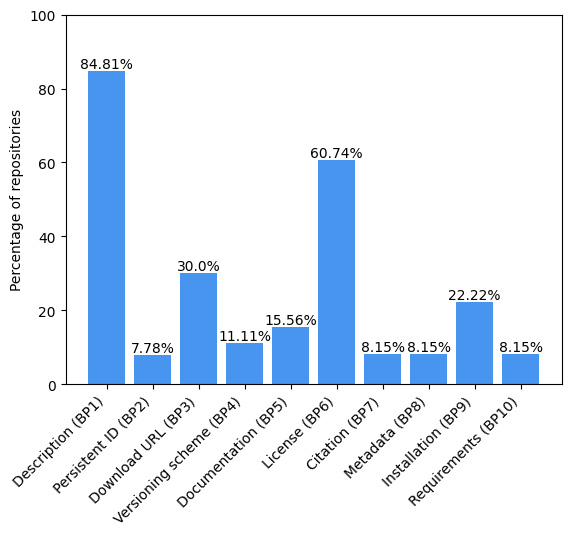

In [24]:
numeric_result_list = dict([a, int(x)] for a, x in result_list.items()) 

labels_BP = ['Description (BP1)',
            'Persistent ID (BP2)',
            'Download URL (BP3)',
            'Versioning scheme (BP4)',
            'Documentation (BP5)',
            'License (BP6)',
            'Citation (BP7)',
            'Metadata (BP8)',
            'Installation (BP9)',
            'Requirements (BP10)']

bars = plt.bar(*zip(*BP_results.items()), color='#4895ef')
plt.ylabel('Percentage of repositories')
plt.xticks(range(len(BP_results)), list(labels_BP), rotation=45, ha='right')
plt.ylim((0,100))

for bar in bars:
    height = bar.get_height()
    percentage = str(round(height,2)) + '%'
    plt.text(bar.get_x() + bar.get_width() / 2, height, percentage, ha='center', va='bottom')


plt.savefig('general_bp.png',dpi=400,bbox_inches = "tight") 
plt.show()

#### Specific plots for citations and descriptions

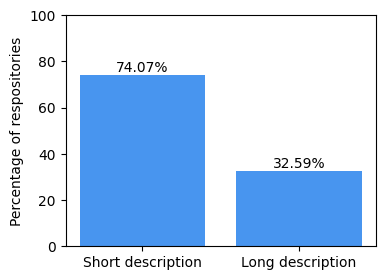

In [25]:
labels_desc = ['Short description', 'Long description']
values_desc = [numeric_result_list['total_short_desc']*100/int(result_list['total_repos']),
               numeric_result_list['total_long_desc']*100/int(result_list['total_repos'])]

plt.figure(figsize=(4,3))
bars = plt.bar(labels_desc, values_desc, color='#4895ef')
plt.ylabel('Percentage of respositories')
plt.ylim((0,100))

for bar in bars:
    height = bar.get_height()
    percentage = str(round(height,2)) + '%'
    plt.text(bar.get_x() + bar.get_width() / 2, height, percentage, ha='center', va='bottom')

plt.savefig('descriptions.png',dpi=400,bbox_inches = "tight") 
plt.show()

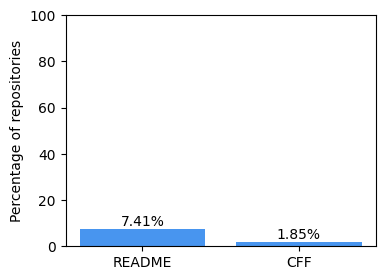

In [26]:
labels_cite = ['README', 'CFF']
values_cite = [numeric_result_list['readme_citation']*100/int(result_list['total_repos']),
               numeric_result_list['cff_citation']*100/int(result_list['total_repos'])]

plt.figure(figsize=(4,3))
bars = plt.bar(labels_cite, values_cite, color='#4895ef')
plt.ylabel('Percentage of repositories')
plt.ylim((0,100))
for bar in bars:
    height = bar.get_height()
    percentage = str(round(height,2)) + '%'
    plt.text(bar.get_x() + bar.get_width() / 2, height, percentage, ha='center', va='bottom')


plt.savefig('citations.png',dpi=400,bbox_inches = "tight") 
plt.show()